# 0005.0000 Modeling - Classifiers + Probability Calibration

In [1]:
import pathlib
import sys
import joblib

import pandas as pd
import numpy as np
import missingno as msno

# import scipy.stats as stats
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# from scipy.stats import poisson, nbinom


import matplotlib.pyplot as plt
# import matplotlib.ticker as ticker
# import seaborn as sns

%matplotlib inline

# Load the "autoreload" extension
%load_ext autoreload
# always reload all modules
%autoreload 2
#add the 'src' directory to path to import modules
PROJECT_DIR = pathlib.Path.cwd().resolve().parent
sys.path.append(str(PROJECT_DIR))

from src.visualization.visualize import get_model_diagnosis
from src.visualization.visualize import extend_cols
from src.data.transform_long_to_wide import run_transform_ts_to_supervised
from src.data.transformed_to_all_stacked import transformed_to_all_stacked
from src.data.stacked_to_ts_featured import clean_df
from src.models.metrics import insert_rps

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

SAMPLE_DIR = PROJECT_DIR / 'data' / 'sample'
SAMP_STACKED_DIR = SAMPLE_DIR / '01-stacked-seasons'
SAMP_FEATURED_DIR = SAMPLE_DIR / '02-featured'
SAMP_TRANSFORMED_DIR = SAMPLE_DIR / '03-transformed'

# fn = '2007-2008__2017-2018.csv'
# EDA_FP = SAMPLE_DIR / '01-stacked-seasons' / 'germany' / 'bundesliga' / fn
# SAVED_IMAGES_DIR = PROJECT_DIR / 'notebooks' / 'saved-images'

fn = '2007-2008__2017-2018.csv'
SAMP_STACKED_FP = SAMP_STACKED_DIR / 'germany' / 'bundesliga' / fn
SAMP_FEATURED_FP = SAMP_FEATURED_DIR / 'germany' / 'bundesliga' / fn
SAMP_TRANSFORMED_FP = SAMP_TRANSFORMED_DIR / 'germany' / 'bundesliga' / fn
SAMP_MODEL_FP = SAMPLE_DIR / 'models' / 'optimized-model.joblib'
SAMP_CAL_FP = SAMPLE_DIR / 'models' / 'calibration-model.joblib'
SAVE_FP = SAMPLE_DIR / 'check-output' / 'test.csv'

In [2]:
SAMP_FEATURED_SUBDIRS  = str(SAMP_FEATURED_DIR) + '/*/'
SAMP_TRANSFORMED_SUBDIRS = str(SAMP_TRANSFORMED_DIR) + '/*/' 

In [3]:
!tree $SAMPLE_DIR -n

/media/david/5C14F53A14F517AA/code/ana_py37/projects/soccer-predictions/data/sample
├── 01-stacked-seasons
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 02-featured
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 03-transformed
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 04-all-stacked
│   ├── 2007-2008__2009-2010.csv
│   ├── 2007-2008__2017-2018.csv
│   ├── germany
│   │   └── bundesliga
│   │       └── 2007-2008__2017-2018.csv
│   └── italy
│       └── serie-a
│           └── 2010-2011__2017-2018.csv
├── check-output
│   └── test.csv
└── models
    ├── calibration-model.joblib
    ├── good-calibration-model.joblib
    └── optimized-model.joblib

16 directories, 11 files


## 6. Select, Impute, Compress the Features

In [4]:
df_trans = pd.read_csv(SAMP_TRANSFORMED_FP,
                       parse_dates=['date']).sort_values(by=['date', 'h', 'a']).reset_index(drop=True)
# Sort the features

In [5]:
df_temp = df_trans.copy(deep=True)

from src.features.manipulation import (cut_historical_games,
                                       select_features,
                                       get_feature_name_stubs_from_base,
                                       get_base_features,
                                       get_df_from_base_features,
                                       get_features_df,
                                       get_non_features_df,
                                       get_target_df)

### Pre-Process

##### Select Features

There are so many features, it is a bit overwhelming, so we will focus on a few of them for the purposes of illustrating the concepts of the modeling strategy

#### Nomenclature

+ base_feature - ftGoals, htGoals, ...
+ feature_stub_set - h_h_ftGoals, a_a_ftGoals, h_a_ftGoals, a_h_ftGoals etc
+ feature_col_set - h_h_ftGoals-1, h_h_ftGoals-2, h_h_ftGoals-3, ..., a_h_ftGoals-16

In [6]:
base_features = get_base_features(df_temp)
base_features

['corners',
 'fouls',
 'ftGoals',
 'htGoals',
 'impliedDraw',
 'impliedLose',
 'impliedWin',
 'poissDraw',
 'poissLose',
 'poissWin',
 'redCards',
 'shots',
 'shotsOnTarget',
 'yellowCards']

In [7]:
selected_base_features = base_features
# selected_base_features = ['ftGoals', 'htGoals', 'shots']#  base_features
# selected_base_features = ['impliedWin', 'impliedDraw',  'impliedLose', 'poissWin', 'poissDraw', 'poissLose']#  base_features
selected_base_features = ['redCards', 'yellowCards']#  base_features
# selected_base_features = ['corners', 'fouls']#  base_features
# selected_base_features = ['poissWin', 'poissDraw', 'poissLose',
#                           'impliedWin', 'impliedDraw', 'impliedLose',
#                          'ftGoals', 'htGoals', 'shots']#  base_features
df_select_features = get_df_from_base_features(df_trans, selected_base_features)
df_select_features.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,a_a_redCards-0,h_h_redCards-0,a_a_redCards-1,a_h_redCards-1,h_a_redCards-1,h_h_redCards-1,a_a_redCards-2,a_h_redCards-2,h_a_redCards-2,h_h_redCards-2,a_a_redCards-3,a_h_redCards-3,h_a_redCards-3,h_h_redCards-3,a_a_redCards-4,a_h_redCards-4,h_a_redCards-4,h_h_redCards-4,a_a_redCards-5,a_h_redCards-5,h_a_redCards-5,h_h_redCards-5,a_a_redCards-6,a_h_redCards-6,h_a_redCards-6,h_h_redCards-6,a_a_redCards-7,a_h_redCards-7,h_a_redCards-7,h_h_redCards-7,a_a_redCards-8,a_h_redCards-8,h_a_redCards-8,h_h_redCards-8,a_a_redCards-9,a_h_redCards-9,h_a_redCards-9,h_h_redCards-9,a_a_redCards-10,a_h_redCards-10,h_a_redCards-10,h_h_redCards-10,a_a_redCards-11,a_h_redCards-11,h_a_redCards-11,h_h_redCards-11,a_a_redCards-12,a_h_redCards-12,h_a_redCards-12,h_h_redCards-12,a_a_redCards-13,a_h_redCards-13,h_a_redCards-13,h_h_redCards-13,a_a_redCards-14,a_h_redCards-14,h_a_redCards-14,h_h_redCards-14,a_a_redCards-15,a_h_redCards-15,h_a_redCards-15,h_h_redCards-15,a_a_redCards-16,a_h_redCards-16,h_a_redCards-16,h_h_redCards-16,a_h_redCards-17,h_a_redCards-17,a_a_yellowCards-0,h_h_yellowCards-0,a_a_yellowCards-1,a_h_yellowCards-1,h_a_yellowCards-1,h_h_yellowCards-1,a_a_yellowCards-2,a_h_yellowCards-2,h_a_yellowCards-2,h_h_yellowCards-2,a_a_yellowCards-3,a_h_yellowCards-3,h_a_yellowCards-3,h_h_yellowCards-3,a_a_yellowCards-4,a_h_yellowCards-4,h_a_yellowCards-4,h_h_yellowCards-4,a_a_yellowCards-5,a_h_yellowCards-5,h_a_yellowCards-5,h_h_yellowCards-5,a_a_yellowCards-6,a_h_yellowCards-6,h_a_yellowCards-6,h_h_yellowCards-6,a_a_yellowCards-7,a_h_yellowCards-7,h_a_yellowCards-7,h_h_yellowCards-7,a_a_yellowCards-8,a_h_yellowCards-8,h_a_yellowCards-8,h_h_yellowCards-8,a_a_yellowCards-9,a_h_yellowCards-9,h_a_yellowCards-9,h_h_yellowCards-9,a_a_yellowCards-10,a_h_yellowCards-10,h_a_yellowCards-10,h_h_yellowCards-10,a_a_yellowCards-11,a_h_yellowCards-11,h_a_yellowCards-11,h_h_yellowCards-11,a_a_yellowCards-12,a_h_yellowCards-12,h_a_yellowCards-12,h_h_yellowCards-12,a_a_yellowCards-13,a_h_yellowCards-13,h_a_yellowCards-13,h_h_yellowCards-13,a_a_yellowCards-14,a_h_yellowCards-14,h_a_yellowCards-14,h_h_yellowCards-14,a_a_yellowCards-15,a_h_yellowCards-15,h_a_yellowCards-15,h_h_yellowCards-15,a_a_yellowCards-16,a_h_yellowCards-16,h_a_yellowCards-16,h_h_yellowCards-16,a_h_yellowCards-17,h_a_yellowCards-17
0,germany,bundesliga,2007-2008,stuttgart,schalke,2007-08-10,2.0,2.0,draw,0.0,23.0,1.0,0.285412,0.391387,0.323201,NaN,NaN,NaN,0.0,10.0,4.0,3.0,2.87,2.85,3.20,2.92,0.275,0.275,0.45,3.25,3.20,3.30,3.18,9.0,19.0,0.0,0.285412,0.323201,0.391387,NaN,NaN,NaN,0.0,16.0,7.0,4.0,2.37,2.30,2.55,2.30,0.323201,0.285412,0.391387,2,0,1,0,0.003268,1.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,germany,bundesliga,2007-2008,bayern-munich,hansa-rostock,2007-08-11,3.0,0.0,hwin,1.0,13.0,0.0,0.154126,0.797203,0.048671,NaN,NaN,NaN,

Select all features for the last n games defined in `n_back`

We can either drop all games where the teams have not played, or we can impute

This is quite a big notebook, so for the sake of brevity we will drop all games unless each team has played n previous games


In [8]:
n_back=1
df_cut = cut_historical_games(df_select_features, n_back=n_back, drop_all_nan_rows=True, how='any')
df_cut.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,a_a_redCards-1,a_h_redCards-1,h_a_redCards-1,h_h_redCards-1,a_a_yellowCards-1,a_h_yellowCards-1,h_a_yellowCards-1,h_h_yellowCards-1
0,germany,bundesliga,2007-2008,bochum,hamburger-sv,2007-08-24,2.0,1.0,hwin,6.0,20.0,0.0,0.286010,0.309845,0.404145,NaN,NaN,NaN,1.0,13.0,4.0,3.0,2.30,2.2,2.35,2.22,0.275,0.275,0.45,3.25,3.2,3.38,3.22,4.0,27.0,1.0,0.286010,0.404145,0.309845,NaN,NaN,NaN,0.0,11.0,5.0,5.0,3.00,3.0,3.55,3.02,0.404145,0.286010,0.309845,1,1,0,0,0.062092,0.611111,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0
1,germany,bundesliga,2007-2008,bayern-munich,hannover,2007-08-25,3.0,0.0,hwin,3.0,24.0,0.0,0.142110,0.796308,0.061581,NaN,NaN,NaN,1.0,5.0,0.0,5.0,15.00,10.0,15.57,12.26,0.275,0.275,0.45,6.50,6.0,6.50,5.66,7.0,13.0,1.0,0.142110,0.061581,0.796308,NaN,NaN,NaN,0.0,22.0,9.0,2.0,1.16,1.2,1.25,1.20,0.061581,0.142110,0.796308,1,1,0,0,0.081699,0.611111,0.0,0.0,0.0,0.0,5.0,3.0,1.0,0.0
2,germany,bundesliga,2007-2008,bielefeld,hertha-berlin,2007-08-25,2.0,0.0,hwin,6.0,18.0,0.0,0.285412,0.391387,0.323201,NaN,NaN,NaN,0.0,18.0,7.0,2.0,2.87,2.7,3.30,2.86,0.275,0.275,0.45,3.25,3.2,3.30,3.20,4.0,11.0,0.0,0.285412,0.323201,0.391387,NaN,NaN,NaN,0.0,16.0,3.0,1.0,2.37,2.4,2.55,2.33,0.323201,0.285412,0.391387,1,1,0,0,0.081699,0.611111,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,germany,bundesliga,2007-2008,dortmund,energie-cottbus,2007-08-25,3.0,0.0,hwin,11.0,20.0,0.0,0.257032,0.574729,0.168239,NaN,NaN,NaN,0.0,10.0,1.0,3.0,5.50,5.3,6.00,5.19,0.275,0.275,0.45,3.60,3.5,3.85,3.54,7.0,13.0,1.0,0.257032,0.168239,0.574729,NaN,NaN,NaN,0.0,24.0,7.0,0.0,1.61,1.6,1.73,1.62,0.168239,0.257032,0.574729,1,1,0,0,0.081699,0.611111,0.0,0.0,1.0,0.0,3.0,2.0,3.0,3.0
4,germany,bundesliga,2007-2008,leverkusen,karlsruher,2007-08-25,3.0,0.0,hwin,6.0,20.0,0.0,0.256872,0.589005,0.154123,NaN,NaN,NaN,0.0,5.0,2.0,2.0,6.00,5.3,6.30,5.48,0.275,0.275,0.45,3.60,3.5,3.90,3.54,9.0,9.0,3.0,0.256872,0.154123,0.589005,NaN,NaN,NaN,0.0,30.0,15.0,1.0,1.57,1.6,1.69,1.59,0.154123,0.256872,0.589005,1,1,0,0,0.081699,0.611111,0.0,0.0,0.0,0.0,2.0,3.0,1.0,3.0


In [9]:
df_cut.shape

(3168, 67)

In [10]:
print(sum(df_cut.columns.duplicated()))

0


### Compress Feature Space

In [11]:
df_compress = df_cut.copy(deep=True)

def compress_all_features(df_orig, func='mean'):
    df = df_orig.copy(deep=True)
    feature_name_stubs = get_feature_name_stubs_from_base(df, selected_base_features)
    for feature_name_stub in feature_name_stubs:
        cols = [col for col in df.columns if '-' in col and feature_name_stub == col.rsplit('-',1)[0]]
        df[feature_name_stub + '-agg'] = df[cols].agg(func=func, axis=1)
        df.drop(columns = cols, inplace=True)
    return df

def drop_unused_features(df_orig):
    df = df_orig.copy(deep=True)
    redundant_features = [col for col in df.columns if 'agg' not in col and (col[0:2] =='h_' or col[0:2] == 'a_')]
    df.drop(columns=redundant_features, inplace=True)
    return df
    

# compressed_df = compress_all_features(df_compress, func='mean')
# compressed_df2 = drop_unused_features(compressed_df)
# compressed_df2.head()
compressed_df2 = df_compress

In [12]:
compressed_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 67 columns):
nation               3168 non-null object
league               3168 non-null object
season               3168 non-null object
h                    3168 non-null object
a                    3168 non-null object
date                 3168 non-null datetime64[ns]
h_ftGoals            3168 non-null float64
a_ftGoals            3168 non-null float64
result               3168 non-null object
a_corners            3168 non-null float64
a_fouls              3168 non-null float64
a_htGoals            3168 non-null float64
a_impliedDraw        3168 non-null float64
a_impliedLose        3168 non-null float64
a_impliedWin         3168 non-null float64
a_poissDraw          3079 non-null float64
a_poissLose          3079 non-null float64
a_poissWin           3079 non-null float64
a_redCards           3168 non-null float64
a_shots              3168 non-null float64
a_shotsOnTarget      3168 non-nu

## Balance Features

In [13]:
compressed_df3 = compressed_df2.copy(deep=True)
compressed_df3 = compressed_df3.dropna().reset_index(drop=True)

In [14]:
# draws = compressed_df3[compressed_df3['result'] == 'draw']
# hwins = compressed_df3[compressed_df3['result'] == 'hwin'].sample(frac=0.55)
# awins = compressed_df3[compressed_df3['result'] == 'awin'].sample(frac=0.85)
# compressed_df4 = pd.concat([draws, awins, hwins], axis=0).sort_index().reset_index(drop=True)
compressed_df4 = compressed_df3.copy(deep=True)

In [15]:
# print(len(draws))
# print(len(awins))
# print(len(hwins))

In [16]:
compressed_df4.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,a_a_redCards-1,a_h_redCards-1,h_a_redCards-1,h_h_redCards-1,a_a_yellowCards-1,a_h_yellowCards-1,h_a_yellowCards-1,h_h_yellowCards-1
0,germany,bundesliga,2007-2008,wolfsburg,schalke,2007-08-26,1.0,1.0,draw,8.0,13.0,0.0,0.285429,0.272836,0.441735,0.087494,0.871797,0.040058,0.0,33.0,11.0,1.0,2.10,2.00,2.27,2.12,0.275,0.275,0.45,3.25,3.25,3.32,3.23,3.0,13.0,1.0,0.285429,0.441735,0.272836,0.087494,0.040058,0.871797,1.0,10.0,2.0,0.0,3.40,3.40,3.65,3.22,0.441735,0.285429,0.272836,2,0,1,0,0.088235,1.000000,0.0,0.0,0.0,0.0,3.0,2.0,2.0,1.0
1,germany,bundesliga,2007-2008,schalke,leverkusen,2007-08-31,1.0,1.0,draw,4.0,17.0,0.0,0.265131,0.539510,0.195359,0.370216,0.518424,0.111360,0.0,7.0,4.0,3.0,4.75,4.60,5.05,4.51,0.275,0.275,0.45,3.50,3.40,3.55,3.39,6.0,14.0,1.0,0.265131,0.195359,0.539510,0.370216,0.111360,0.518424,0.0,21.0,10.0,0.0,1.72,1.70,1.90,1.76,0.195359,0.265131,0.539510,2,0,1,0,0.091503,1.000000,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0
2,germany,bundesliga,2007-2008,duisburg,bielefeld,2007-09-01,3.0,0.0,hwin,5.0,20.0,0.0,0.286010,0.404145,0.309845,0.077815,0.019070,0.902818,0.0,7.0,2.0,2.0,3.00,2.75,3.40,2.92,0.275,0.275,0.45,3.25,3.25,3.40,3.22,4.0,23.0,0.0,0.286010,0.309845,0.404145,0.077815,0.902818,0.019070,0.0,18.0,8.0,1.0,2.30,2.35,2.40,2.29,0.309845,0.286010,0.404145,1,1,0,0,0.111111,0.611111,0.0,0.0,1.0,0.0,0.0,1.0,4.0,2.0
3,germany,bundesliga,2007-2008,energie-cottbus,nurnberg,2007-09-01,1.0,1.0,draw,8.0,14.0,0.0,0.284505,0.330229,0.385267,0.551509,0.211379,0.237113,1.0,14.0,5.0,1.0,2.40,2.50,2.52,2.44,0.275,0.275,0.45,3.25,3.20,3.32,3.21,4.0,23.0,1.0,0.284505,0.385267,0.330229,0.551509,0.237113,0.211379,0.0,18.0,9.0,3.0,2.80,2.60,3.20,2.72,0.385267,0.284505,0.330229,2,0,1,0,0.111111,1.000000,0.0,0.0,0.0,0.0,2.0,2.0,3.0,2.0
4,germany,bundesliga,2007-2008,hannover,bochum,2007-09-01,3.0,2.0,hwin,4.0,22.0,1.0,0.280374,0.462617,0.257009,0.148240,0.217721,0.632944,0.0,10.0,3.0,1.0,3.60,3.50,4.00,3.54,0.275,0.275,0.45,3.30,3.30,3.50,3.26,2.0,22.0,2.0,0.280374,0.257009,0.462617,0.148240,0.632944,0.217721,0.0,12.0,4.0,3.0,2.00,1.95,2.10,2.01,0.257009,0.280374,0.462617,1,1,0,0,0.111111,0.611111,0.0,0.0,1.0,0.0,2.0,5.0,5.0,3.0


In [17]:
compressed_df4.tail()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,a_a_redCards-1,a_h_redCards-1,h_a_redCards-1,h_h_redCards-1,a_a_yellowCards-1,a_h_yellowCards-1,h_a_yellowCards-1,h_h_yellowCards-1
3074,germany,bundesliga,2017-2018,leverkusen,hannover,2018-05-12,3.0,2.0,hwin,2.0,11.0,0.0,0.134756,0.792683,0.072561,0.195309,0.641564,0.163108,0.0,11.0,4.0,2.0,13.00,10.5,15.00,11.44,0.275,0.275,0.45,7.00,7.25,8.00,6.99,5.0,9.0,2.0,0.134756,0.072561,0.792683,0.195309,0.163108,0.641564,0.0,27.0,8.0,2.0,1.19,1.22,1.26,1.22,0.072561,0.134756,0.792683,1,1,0,0,1.0,0.611111,0.0,0.0,0.0,0.0,1.0,2.0,5.0,2.0
3075,germany,bundesliga,2017-2018,mainz,sv-werder-bremen,2018-05-12,1.0,2.0,awin,7.0,6.0,1.0,0.265108,0.416763,0.318129,0.302663,0.384433,0.312903,0.0,14.0,3.0,1.0,3.00,2.9,3.05,2.89,0.275,0.275,0.45,3.60,3.60,3.90,3.67,3.0,10.0,1.0,0.265108,0.318129,0.416763,0.302663,0.312903,0.384433,0.0,13.0,1.0,0.0,2.29,2.35,2.41,2.32,0.318129,0.265108,0.416763,3,0,0,1,1.0,1.000000,0.0,0.0,0.0,0.0,2.0,3.0,3.0,2.0
3076,germany,bundesliga,2017-2018,sc-freiburg,augsburg,2018-05-12,2.0,0.0,hwin,4.0,17.0,0.0,0.278865,0.484796,0.236338,0.276275,0.287379,0.436345,0.0,5.0,2.0,2.0,4.00,3.9,4.30,3.85,0.275,0.275,0.45,3.39,3.40,3.60,3.40,5.0,13.0,0.0,0.278865,0.236338,0.484796,0.276275,0.436345,0.287379,0.0,12.0,3.0,1.0,1.95,2.00,2.11,2.00,0.236338,0.278865,0.484796,1,1,0,0,1.0,0.611111,1.0,0.0,0.0,0.0,2.0,2.0,3.0,2.0
3077,germany,bundesliga,2017-2018,schalke,eintracht-frankfurt,2018-05-12,1.0,0.0,hwin,3.0,12.0,0.0,0.270632,0.413630,0.315738,0.233668,0.568187,0.198143,0.0,6.0,2.0,2.0,3.00,2.9,3.09,2.89,0.275,0.275,0.45,3.50,3.40,3.60,3.43,4.0,10.0,1.0,0.270632,0.315738,0.413630,0.233668,0.198143,0.568187,0.0,11.0,5.0,0.0,2.29,2.45,2.52,2.41,0.315738,0.270632,0.413630,1,1,0,0,1.0,0.611111,0.0,0.0,0.0,1.0,0.0,2.0,3.0,2.0
3078,germany,bundesliga,2017-2018,wolfsburg,fc-koln,2018-05-12,4.0,1.0,hwin,10.0,17.0,1.0,0.238043,0.580592,0.181366,0.247620,0.544556,0.207823,0.0,6.0,1.0,3.0,5.25,5.0,5.50,4.98,0.275,0.275,0.45,4.00,4.10,4.36,4.11,5.0,12.0,1.0,0.238043,0.181366,0.580592,0.247620,0.207823,0.544556,0.0,16.0,8.0,2.0,1.64,1.65,1.70,1.64,0.181366,0.238043,0.580592,1,1,0,0,1.0,0.611111,0.0,0.0,0.0,0.0,4.0,1.0,1.0,3.0


## 7. Modeling

### Prepare for Data Splitting

Prior to modeling, we will split the DataFrame into 3 parts, all keeping the same row index
+ meta - all meta data
+ X - all features
+ y - target

In [18]:
df_model = compressed_df4.copy(deep=True)
# Reset index prior to any splitting
df_model = df_model.sort_values(by=['date'])
df_model = df_model.reset_index(drop=True)
meta = get_non_features_df(df_model)
meta.head(2)

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight
0,germany,bundesliga,2007-2008,wolfsburg,schalke,2007-08-26,1.0,1.0,draw,8.0,13.0,0.0,0.285429,0.272836,0.441735,0.087494,0.871797,0.040058,0.0,33.0,11.0,1.0,2.10,2.0,2.27,2.12,0.275,0.275,0.45,3.25,3.25,3.32,3.23,3.0,13.0,1.0,0.285429,0.441735,0.272836,0.087494,0.040058,0.871797,1.0,10.0,2.0,0.0,3.40,3.4,3.65,3.22,0.441735,0.285429,0.272836,2,0,1,0,0.088235,1.0
1,germany,bundesliga,2007-2008,schalke,leverkusen,2007-08-31,1.0,1.0,draw,4.0,17.0,0.0,0.265131,0.539510,0.195359,0.370216,0.518424,0.111360,0.0,7.0,4.0,3.0,4.75,4.6,5.05,4.51,0.275,0.275,0.45,3.50,3.40,3.55,3.39,6.0,14.0,1.0,0.265131,0.195359,0.539510,0.370216,0.111360,0.518424,0.0,21.0,10.0,0.0,1.72,1.7,1.90,1.76,0.195359,0.265131,0.539510,2,0,1,0,0.091503,1.0


In [19]:
meta.tail(2)

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight
3077,germany,bundesliga,2017-2018,hoffenheim,dortmund,2018-05-12,3.0,1.0,hwin,3.0,7.0,0.0,0.250874,0.432188,0.316938,0.201886,0.499142,0.298946,0.0,10.0,4.0,0.0,3.00,3.0,3.13,2.95,0.275,0.275,0.45,3.79,3.8,4.25,3.97,2.0,4.0,1.0,0.250874,0.316938,0.432188,0.201886,0.298946,0.499142,0.0,12.0,8.0,0.0,2.20,2.20,2.4,2.18,0.316938,0.250874,0.432188,1,1,0,0,1.0,0.611111
3078,germany,bundesliga,2017-2018,wolfsburg,fc-koln,2018-05-12,4.0,1.0,hwin,10.0,17.0,1.0,0.238043,0.580592,0.181366,0.247620,0.544556,0.207823,0.0,6.0,1.0,3.0,5.25,5.0,5.50,4.98,0.275,0.275,0.45,4.00,4.1,4.36,4.11,5.0,12.0,1.0,0.238043,0.181366,0.580592,0.247620,0.207823,0.544556,0.0,16.0,8.0,2.0,1.64,1.65,1.7,1.64,0.181366,0.238043,0.580592,1,1,0,0,1.0,0.611111


In [20]:
meta.shape

(3079, 59)

In [21]:
X = get_features_df(df_model)
X.head(2)

,a_a_redCards-1,a_h_redCards-1,h_a_redCards-1,h_h_redCards-1,a_a_yellowCards-1,a_h_yellowCards-1,h_a_yellowCards-1,h_h_yellowCards-1
0,0.0,0.0,0.0,0.0,3.0,2.0,2.0,1.0
1,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0


In [22]:
X.shape

(3079, 8)

In [23]:
y = get_target_df(df_model, format='single_ordinal_result_column')
y.head(2)

0    2
1    2
Name: ordinal_result, dtype: int64

In [24]:
y.shape

(3079,)

### Split Into Train Test

In [25]:
test_seasons = ['2016-2017', '2017-2018']

train_full_index = meta[~meta['season'].isin(test_seasons)].index
held_out_test_index = meta[meta['season'].isin(test_seasons)].index

meta_train_full = meta.loc[train_full_index, :]
meta_held_out_test = meta.loc[held_out_test_index, :]

X_train_full = X.loc[train_full_index, :]
X_held_out_test = X.loc[held_out_test_index, :]

y_train_full = y.loc[train_full_index]
y_held_out_test = y.loc[held_out_test_index]

In [26]:
print(meta_train_full.shape)
print(X_train_full.shape)
print(y_train_full.shape)
print()
print(meta_held_out_test.shape)
print(X_held_out_test.shape)
print(y_held_out_test.shape)

(2524, 59)
(2524, 8)
(2524,)

(555, 59)
(555, 8)
(555,)


### Split Out Calibrate

In [27]:
cal_seasons = ['2014-2015', '2015-2016']

train_val_index = meta_train_full[~meta_train_full['season'].isin(cal_seasons)].index
cal_index = meta_train_full[meta_train_full['season'].isin(cal_seasons)].index

meta_train_val = meta_train_full.loc[train_val_index, :]
meta_cal = meta_train_full.loc[cal_index, :]

X_train_val = X_train_full.loc[train_val_index, :]
X_cal = X_train_full.loc[cal_index, :]

y_train_val = y_train_full.loc[train_val_index]
y_cal = y_train_full.loc[cal_index]

In [28]:
print(meta_train_val.shape)
print(X_train_val.shape)
print(y_train_val.shape)
print()
print(meta_cal.shape)
print(X_cal.shape)
print(y_cal.shape)

(1965, 59)
(1965, 8)
(1965,)

(559, 59)
(559, 8)
(559,)


In [29]:
from skoot.preprocessing import SelectiveMinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score
from sklearn.naive_bayes import MultinomialNB, CategoricalNB, GaussianNB
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              ExtraTreesClassifier, AdaBoostClassifier)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import NuSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
import mord as m

# clf = m.LogisticSE(max_iter=1000, alpha=1)
#clf = m.LogisticAT(max_iter=100, alpha=1.0) # Passable
# clf = m.LogisticIT(max_iter=100, alpha=0.0000) # Think profitable
# clf = GaussianNB(priors=[0.45, 0.275, 0.275])
# clf = MultinomialNB(class_prior=[0.45, 0.275, 0.275])
# clf = RandomForestClassifier(max_depth=25, class_weight='balanced')
# clf = MLPClassifier(learning_rate='adaptive', max_iter=1000, activation='relu', learning_rate_init=0.001) # - good 
# clf = MLPClassifier(hidden_layer_sizes=(100, ),learning_rate='constant', max_iter=5000,
#                     activation='relu', learning_rate_init=0.01) # good

# clf = RandomForestClassifier(class_weight='balanced', n_estimators=200,
#                              criterion='entropy', bootstrap=False, oob_score=False)

# clf = GradientBoostingClassifier() # Think Profitable
# clf = GradientBoostingClassifier(n_estimators=50,learning_rate=1.105, max_depth=10) # Think Profitable
# clf = AdaBoostClassifier()
# clf = ExtraTreesClassifier(n_estimators=20, criterion='entropy')
# clf = MLPClassifier()
# clf = QuadraticDiscriminantAnalysis(priors=[0.45, 0.275, 0.275])
# clf = QuadraticDiscriminantAnalysis()
# clf = KNeighborsClassifier(n_neighbors=10, weights='distance', algorithm='brute',) # good !!
# clf = GaussianProcessClassifier()
# clf = DecisionTreeClassifier()
clf = LogisticRegression(max_iter=1000)
# clf = XGBClassifier(objective="multi:softprob")
# clf = LinearDiscriminantAnalysis()
# clf = NuSVC(probability=True, class_weight='balanced')

n_splits=2
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
srs = SelectiveMinMaxScaler(trans_col_name='')

Validation Fold: 1
Average Calibration Error:  0.402
Expected Calibration Error: 0.463
Maximum Calibration Error:  0.516
Number of Instances: 983


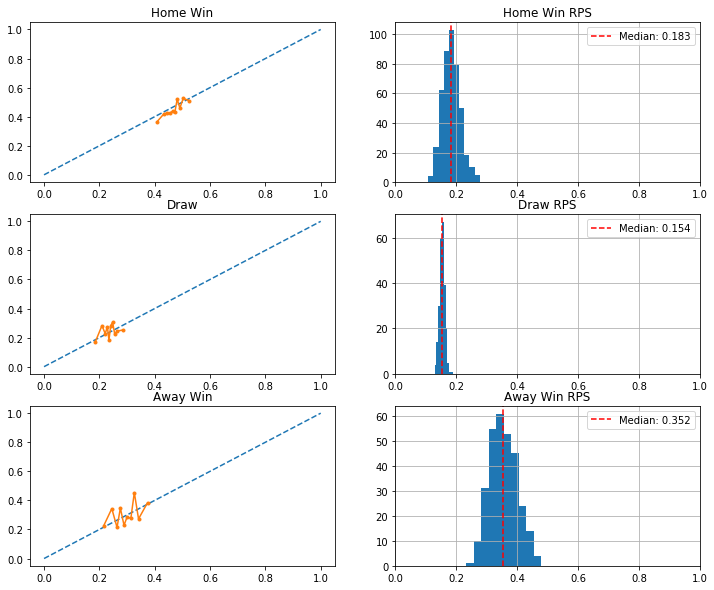


Validation Fold: 2
Average Calibration Error:  0.505
Expected Calibration Error: 0.468
Maximum Calibration Error:  0.639
Number of Instances: 982


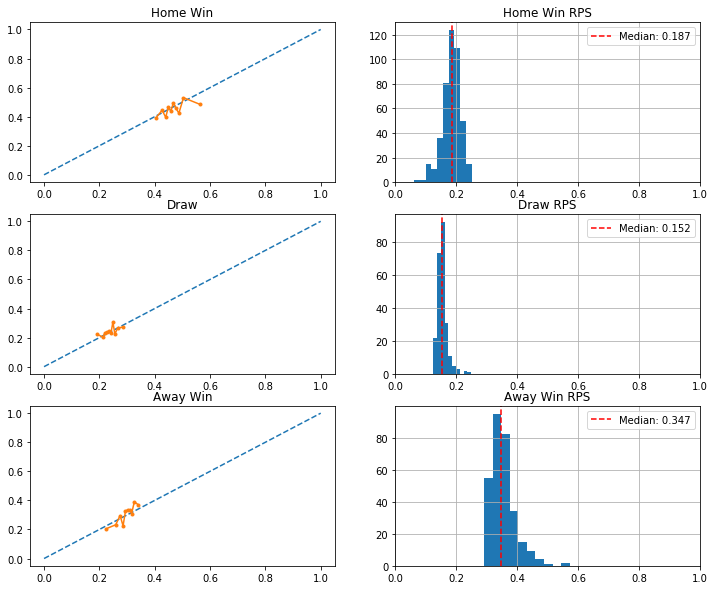

In [30]:
# validate_dfs = []

# rps_adj_scores = []
# bal_acc_scores = []

def run_fit_validate(X, y, X_cal, y_cal, meta_train_val, skf, clf, sig_clf):
    n = 0
    validate_dfs = []
  

    for fit_indices, validate_indices in skf.split(X, y):

        X_fit = X.iloc[fit_indices]
        y_fit = y.iloc[fit_indices]

        X_validate = X.iloc[validate_indices]
        y_validate = y.iloc[validate_indices]

        meta_fit = meta_train_val.iloc[fit_indices]
        meta_validate = meta_train_val.iloc[validate_indices]

        # X_fit = srs.fit_transform(X_fit)
        clf.fit(X_fit, y_fit)

        # X_validate = srs.transform(X_validate)
        validate_preds = clf.predict_proba(X_validate)

        # Probability calibration

        sig_clf.fit(X_cal, y_cal)
        sig_validate_preds = sig_clf.predict_proba(X_validate)

        #Build the DataFrame with the results for the validation data
        validate_preds_df = pd.DataFrame(sig_validate_preds, columns = clf.classes_, index = meta_validate.index)

        df_validate = pd.concat([meta_validate, X_validate, validate_preds_df], sort=False, axis=1)
        df_validate = insert_rps(df_validate)
        df_validate = insert_rps(df_validate,
                                 prob_cols=['implied_hwin', 'implied_draw', 'implied_awin'],
                                 return_col_prefix='bookie')
        df_validate = insert_rps(df_validate,
                                 prob_cols=['base_hwin_prob', 'base_draw_prob', 'base_awin_prob'],
                                 return_col_prefix='baseline')


        df_validate['pred_class'] = df_validate[[1,2, 3]].idxmax(axis=1)
        df_validate['pred_result'] = df_validate['pred_class'].map({1:'hwin', 2: 'draw', 3: 'awin'})
        #bal_acc_scores.append(balanced_accuracy_score(df_validate['result'], df_validate['pred_result'], adjusted=True))


        df_validate['n_fold'] = n
        n += 1

        validate_dfs.append(df_validate)
    for df in validate_dfs:
        print(f"Validation Fold: {df['n_fold'].unique()[0]+1}")
        get_model_diagnosis(df, add_baseline=True)
        plt.show();
        print()

sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
run_fit_validate(X_train_val, y_train_val, X_cal, y_cal, meta_train_val, skf, clf, sig_clf)



In [31]:
joblib.dump(clf, SAMP_MODEL_FP)
joblib.dump(sig_clf, SAMP_CAL_FP)

['/media/david/5C14F53A14F517AA/code/ana_py37/projects/soccer-predictions/data/sample/models/calibration-model.joblib']

## 8. Simulate Gambling in Test Data

In [32]:
clf = joblib.load(SAMP_MODEL_FP)
clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
sig_clf = joblib.load(SAMP_CAL_FP)
sig_clf

CalibratedClassifierCV(base_estimator=LogisticRegression(C=1.0,
                                                         class_weight=None,
                                                         dual=False,
                                                         fit_intercept=True,
                                                         intercept_scaling=1,
                                                         l1_ratio=None,
                                                         max_iter=1000,
                                                         multi_class='auto',
                                                         n_jobs=None,
                                                         penalty='l2',
                                                         random_state=None,
                                                         solver='lbfgs',
                                                         tol=0.0001, verbose=0,
                                             

Average Calibration Error:  0.503
Expected Calibration Error: 0.469
Maximum Calibration Error:  0.625
Number of Instances: 555


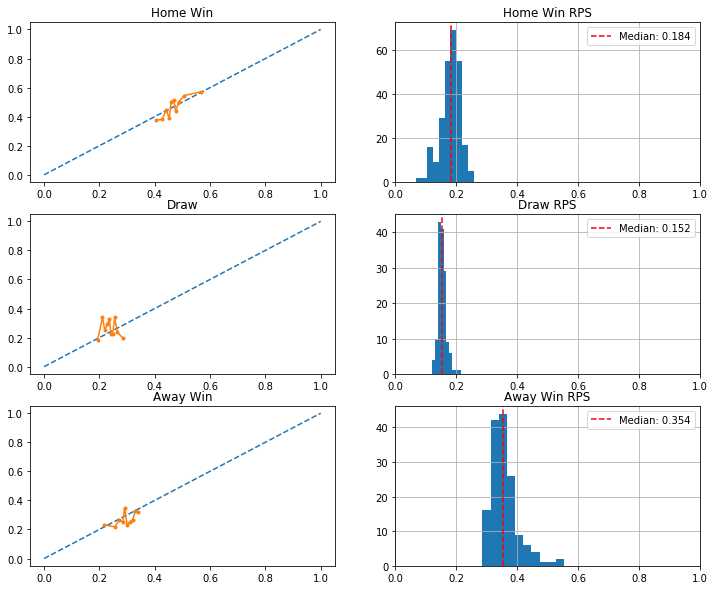

In [34]:
def predict_on_test(X_t, y_y, meta_t, clf, srs):
    meta_t = meta_held_out_test.copy(deep=True)
    X_t = X_held_out_test.copy(deep=True)
    y_t = y_held_out_test.copy(deep=True)

    meta_t.reset_index(drop=True, inplace=True)
    X_t.reset_index(drop=True, inplace=True)
    y_t.reset_index(drop=True, inplace=True)
    
    
    # X_t = srs.transform(X_t)
    test_preds = sig_clf.predict_proba(X_t)
    test_preds_df = pd.DataFrame(test_preds, columns = clf.classes_)
    df_test = pd.concat([meta_t, test_preds_df], sort=False, axis=1)

    df_test['pred_class'] = df_test[[1,2, 3]].idxmax(axis=1)
    df_test['pred_result'] = df_test['pred_class'].map({1:'hwin', 2: 'draw', 3: 'awin'})

    df_test = insert_rps(df_test)
    df_test = insert_rps(df_test,
                             prob_cols=['implied_hwin', 'implied_draw', 'implied_awin'],
                             return_col_prefix='bookie')
    df_test = insert_rps(df_test,
                             prob_cols=['base_hwin_prob', 'base_draw_prob', 'base_awin_prob'],
                             return_col_prefix='baseline')
    return df_test


def bet_all_positive_EVs(df_orig, param_dict):
    df = df_orig.copy(deep=True)
    # # Betting Strategy # 1
    # # ## EV > Threshold ##
    EV_threshold = param_dict['EV_threshold']
    mask = (df[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']] >= EV_threshold).values
    df[['hwin_bet', 'draw_bet', 'awin_bet']] = pd.DataFrame(mask)
    return df


def bet_highest_EV_per_game(df_orig, param_dict):
    # Betting Strategy # 2
    ## EV > Threshold - Bet on Maximum EV for each Game ##
    df = df_orig.copy(deep=True)
    EV_threshold = param_dict['EV_threshold']
    mask1 = (df[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']] >= EV_threshold).values
    mask2 = df[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']].values.max(axis=1,keepdims=1) == \
                df[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']].values

    mask = np.logical_and(mask1, mask2)
    df[['hwin_bet', 'draw_bet', 'awin_bet']] = pd.DataFrame(mask)
    return df


def bet_single_type_positive_EV(df_orig, param_dict={'EV_threshold': 0.0, 'bet_type': 'hwin'}):    
    # # Betting Strategy # 4
    # ## EV > Threshold - Bet on Maximum EV for each Game, only bet on draws##
    # EV_threshold = 0.1
    df = df_orig.copy(deep=True)
    EV_threshold = param_dict['EV_threshold']
    bet_type = param_dict['bet_type']
    mask1 = (df[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']] >= EV_threshold).values
    mask2 = df[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']].values.max(axis=1,keepdims=1) == \
                 df[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']].values

    mask = np.logical_and(mask1, mask2)
    if bet_type == 'hwin':
        mask[:,1] = 0
        mask[:,2] = 0
    if bet_type == 'draw':
        mask[:,0] = 0
        mask[:,2] = 0
    if bet_type == 'awin':
        mask[:,0] = 0
        mask[:,1] = 0
    df[['hwin_bet', 'draw_bet', 'awin_bet']] = pd.DataFrame(mask)
    return df


def bet_EV_threshold_odds_threshold(df_orig, params_dict):
    df = df_orig.copy(deep=True)
    # # Betting Strategy # 5
    # # ## EV > EV_Threshold - Odds < odds_threshold ##
    # EV_threshold = 0.1
    # odds_threshold = 6.0

    # mask1 = (df_test[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']] >= EV_threshold).values
    # mask2 = (df_test[['hwinOddsMean', 'drawOddsMean', 'awinOddsMean']] <= odds_threshold).values

    # mask = np.logical_and(mask1, mask2)

    # df_test['hwin_bet'] = 0 ; df_test['draw_bet'] = 0 ; df_test['awin_bet'] = 0
    # df_test[['hwin_bet', 'draw_bet', 'awin_bet']] = mask
    return df


def do_bets(df_orig):
    df = df_orig.copy(deep=True)

    # Do betting
    for n, bet_type in zip([1, 2, 3], ['hwin', 'draw', 'awin']):
        # Condition 1 - Place bet and bet wins
        # Condition 2 - Place bet and bet loses
        conditions = [(df[bet_type + '_bet'] == 1) & (df['ordinal_result_' + str(n)] == 1),
                      (df[bet_type + '_bet'] == 1) & (df['ordinal_result_' + str(n)] == 0)]
        # Choices - 1 - Winnings; 2 - Loss
        choices = [(df[bet_type + 'OddsMax']-1), -1]
        # Default - no bet placed
        df[bet_type +'_rets'] = np.select(conditions, choices, default=0)
        
    # Works if placing a single bet [per game]
    def get_placed_bet(row):
        if row[0]:
            return 'hwin_bet'
        elif row[1]:
            return 'draw_bet'
        elif row[2]:
            return 'awin_bet'
        else:
            return 'no_bet'
    df['placed_bet'] = df[['hwin_bet', 'draw_bet', 'awin_bet']].apply(get_placed_bet, axis=1)

    # Get total Return per Game
    df['game_ret'] = df[['hwin_rets', 'draw_rets', 'awin_rets']].sum(axis=1)
    
    return df
        
        
def calculate_EVs(df_orig):
    df = df_orig.copy(deep=True)
    df['hwin_unit_EV'] = (df[1]* (df['hwinOddsMean']-1)) + ((1- df[1]) * -1)
    df['draw_unit_EV'] = (df[2]* (df['drawOddsMean']-1)) + ((1- df[2]) * -1)
    df['awin_unit_EV'] = (df[3]* (df['awinOddsMean']-1)) + ((1- df[3]) * -1)
    return df
    
    
def simulate_betting(df,
                     strategy='highest_EV_per_game',
                     param_dict={'EV_threshold': 0.0}):
    
    df = calculate_EVs(df)
    
    if strategy == 'highest_EV_per_game':
        df = bet_highest_EV_per_game(df, param_dict)
    if strategy == 'all_positive_EVs':
        df = bet_all_positive_EVs(df, param_dict)
    if strategy == 'single_bet_type_positive_EV':
        df = bet_single_bet_positive_EV(df, param_dict)
        
    df = do_bets(df)
    return df



df = predict_on_test(X_held_out_test, y_held_out_test, meta_held_out_test, clf, srs)

get_model_diagnosis(df, add_baseline=True)
plt.show();


In [35]:
df = simulate_betting(df)

df.to_csv(SAVE_FP, index=False)

df.head(15)

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,1,2,3,pred_class,pred_result,model_rps,bookie_rps,baseline_rps,hwin_unit_EV,draw_unit_EV,awin_unit_EV,hwin_bet,draw_bet,awin_bet,hwin_rets,draw_rets,awin_rets,placed_bet,game_ret
0,germany,bundesliga,2016-2017,ingolstadt,eintracht-frankfurt,2016-09-20,0.0,2.0,awin,4.0,19.0,1.0,0.294089,0.424796,0.281115,0.291278,0.513677,0.195046,0.0,9.0,5.0,1.0,3.40,3.50,3.70,3.43,0.275,0.275,0.45,3.25,3.25,3.38,3.26,6.0,20.0,0.0,0.294089,0.281115,0.424796,0.291278,0.195046,0.513677,0.0,13.0,3.0,0.0,2.25,2.20,2.40,2.22,0.281115,0.294089,0.424796,3,0,0,1,0.101307,1.000000,0.455741,0.267711,0.276548,1,hwin,0.365541,0.348624,0.364063,0.011745,-0.127262,-0.051440,True,False,False,-1.00,0.0,0.0,hwin_bet,-1.00
1,germany,bundesliga,2016-2017,sc-freiburg,hamburger-sv,2016-09-20,1.0,0.0,hwin,0.0,17.0,0.0,0.279718,0.413495,0.306787,0.023391,0.956008,0.007432,0.0,7.0,0.0,0.0,3.10,3.10,3.26,3.13,0.275,0.275,0.45,3.40,3.40,3.57,3.41,7.0,17.0,0.0,0.279718,0.306787,0.413495,0.023391,0.007432,0.956008,0.0,19.0,4.0,1.0,2.30,2.30,2.40,2.30,0.306787,0.279718,0.413495,1,1,0,0,0.101307,0.611111,0.489205,0.280050,0.230745,1,hwin,0.157077,0.219053,0.189062,0.125171,-0.045030,-0.277768,True,False,False,1.40,0.0,0.0,hwin_bet,1.40
2,germany,bundesliga,2016-2017,bayern-munich,hertha-berlin,2016-09-21,3.0,0.0,hwin,2.0,9.0,0.0,0.106110,0.837714,0.056176,1.000000,0.000000,0.000000,0.0,2.0,2.0,0.0,17.00,17.50,25.30,21.23,0.275,0.275,0.45,9.00,8.75,9.00,7.87,6.0,9.0,1.0,0.106110,0.056176,0.837714,1.000000,0.000000,0.000000,0.0,16.0,7.0,1.0,1.14,1.14,1.20,1.15,0.056176,0.106110,0.837714,1,1,0,0,0.117647,0.611111,0.424471,0.257078,0.318450,1,hwin,0.216322,0.014746,0.189062,-0.511858,1.023208,5.760703,False,False,True,0.00,0.0,-1.0,awin_bet,-1.00
3,germany,bundesliga,2016-2017,leverkusen,augsburg,2016-09-21,0.0,0.0,draw,3.0,16.0,0.0,0.210690,0.653866,0.135444,1.000000,0.000000,0.000000,0.0,5.0,2.0,2.0,7.00,6.25,7.47,6.69,0.275,0.275,0.45,4.50,4.40,4.74,4.38,6.0,14.0,0.0,0.210690,0.135444,0.653866,1.000000,0.000000,0.000000,0.0,14.0,6.0,0.0,1.45,1.50,1.55,1.49,0.135444,0.210690,0.653866,2,0,1,0,0.117647,1.000000,0.481786,0.210478,0.307736,1,hwin,0.163409,0.222943,0.139062,-0.282139,-0.078104,1.058752,False,False,True,0.00,0.0,-1.0,awin_bet,-1.00
4,germany,bundesliga,2016-2017,rb-leipzig,borussia-monchengladbach,2016-09-21,1.0,1.0,draw,2.0,16.0,0.0,0.274933,0.404313,0.320755,1.000000,0.000000,0.000000,0.0,3.0,1.0,2.0,3.00,2.85,3.00,2.83,0.275,0.275,0.45,3.50,3.30,3.74,3.43,5.0,15.0,1.0,0.274933,0.320755,0.404313,1.000000,0.000000,0.000000,0.0,9.0,5.0,1.0,2.38,2.50,2.54,2.46,0.320755,0.274933,0.404313,2,0,1,0,0.117647,1.000000,0.447161,0.217267,0.335572,1,hwin,0.156281,0.133176,0.139062,0.100017,-0.254774,-0.050332,True,False,False,-1.00,0.0,0.0,hwin_bet,-1.00
5,germany,bundesliga,2016-2017,schalke,fc-koln,2016-09-21,1.0,3.0,awin,4.0,9.0,1.0,0.280624,0.454343,0.265033,1.000000,0.000000,0.000000,0.0,9.0,5.0,1.0,3.60,3.50,3.70,3.50,0.275,0.275,0.45,3.40,3.50,3.62,3.44,8.0,17.0,1.0,0.280624,0.265033,0.454343,1.000000,0.000000,0.000000,0.0,18.0,8.0,2.0,2.10,2.10,2.18,2.11,0.265033,0.280624,0.454343,3,0,0,1,0.117647,1.000000,0.470193,0.219410,0.310397,1,hwin,0.348317,0.373302,0.364063,-0.007893,-0.245229,0.086389,False,False,True,0.00,0.0,2.7,awin_bet,2.70
6,germany,bundesliga,2016-2017,sv-werder-bremen,mainz,2016-09-21,1

pred hwin: 37.09 on 282 bets
pred draw: -1.3399999999999999 on 5 bets
pred awin: -38.68999999999999 on 256 bets
543 bets returning -2.9399999999999977 over 555 games
Overall Return: -0.005

On Sided t Test Against against Mean = 0:
	t_stat:	-0.065
	p_val:	0.474


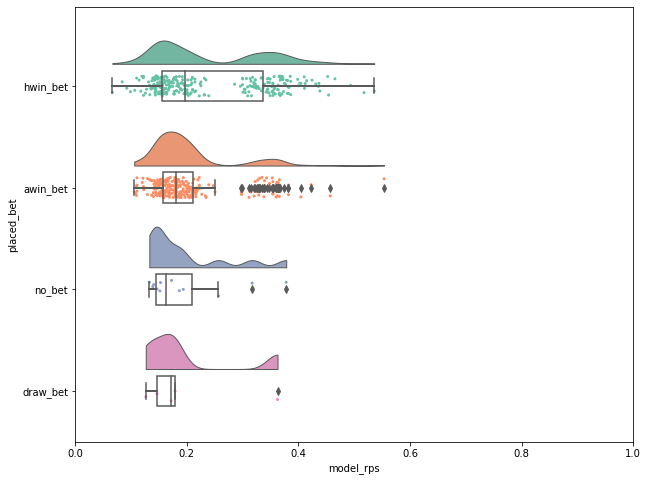

In [36]:
import ptitprince as pt
from scipy.stats import ttest_1samp

def get_betting_diagnosis(df):
    fig, ax = plt.subplots(figsize=(10,8))
    ax = pt.RainCloud(x='placed_bet', y='model_rps', data=df, width_viol=0.8, width_box=0.3,
                  orient='h', pointplot=False)
    ax.set_xlim(0.0, 1.0)
    
    bet_rets = pd.concat([df['hwin_rets'], df['draw_rets'], df['awin_rets']], axis=0)
    bet_rets = bet_rets[bet_rets != 0].values
    res = ttest_1samp(bet_rets, 0)
    t_stat = res[0]
    p_val = res[1]/2
    
    # Swarm Plot on Probabilities her
    # sns.catplot(x="day", y="total_bill", kind="swarm", data=tips);
    
    n_bets = df[["hwin_bet" , "draw_bet", "awin_bet"]].sum().sum()
    print(f'pred hwin: {df["hwin_rets"].sum()} on {df["hwin_bet"].sum()} bets')
    print(f'pred draw: {df["draw_rets"].sum()} on {df["draw_bet"].sum()} bets')
    print(f'pred awin: {df["awin_rets"].sum()} on {df["awin_bet"].sum()} bets')
    print(f'{n_bets} bets returning {df["game_ret"].sum()} over {len(df)} games')
    print(f'Overall Return: {df["game_ret"].sum()/n_bets:.3f}')
    print()
    print(f'On Sided t Test Against against Mean = 0:\n\tt_stat:\t{t_stat:.3f}\n\tp_val:\t{p_val:.3f}')
    return fig, ax


get_betting_diagnosis(df)
plt.show();